# Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста

## Шаг 1. Обзор данных

In [1]:
# выгрузка необходимых библиотек для работы с данными
import pandas as pd 
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [9]:
# функция для просмотра информации и первых строк таблиц
def inform(df):
    df.info()
    print(' '*50)
    display(df.head())
    return

In [10]:
# загрузка данных о гипотезах, заказах и посетителях в переменные
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv')
)

In [12]:
# общая информация и первые 5 строк таблиц
tables = [hypothesis, orders, visitors]

for df in tables:
    inform(df)
    print('*'*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
                                                  


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
                                                  


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
                                                  


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


****************************************************************************************************


**Описание данных таблицы `hypothesis`:**

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Описание данных таблицы `orders`:**

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

**Описание данных таблицы `visitors`:**

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

В названиях столбцов присутствует 2 нарушения стиля:
1. Строчные буквы сочетаются с прописными.
2. Несколько слов следует записывать "змеиным_регистром"

Также будет изменен тип данных в столбцах с датой для всех таблиц в DateTime для удобства при проведении анализа.

## Шаг 2. Предобработка данных

### Стиль заголовков

In [13]:
# приведение названий столбцов к общему (нижнему) регистру в таблице hypothesis
hypothesis.columns = [x.lower() for x in hypothesis.columns]
print(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')


In [14]:
# приведение названий столбцов к нужным регистрам в таблице orders
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
print(orders.columns)

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')


### Преобразование данных о времени

In [15]:
# преобразование данных о времени в таблице orders
orders['date'] = pd.to_datetime(orders['date'])

In [16]:
# преобразование данных о времени в таблице visitors
visitors['date'] = pd.to_datetime(visitors['date'])

###  Корректность разбиения пользователей на группы

In [17]:
# подсчет пользователей, попавших в группы А и В
ab = orders.groupby('visitor_id').agg({'group': 'nunique'}).query('group == 2').count()
print(f'Пользователи, попавшие в группу А и В:{ab}')

# подсчет уникальных пользователей
uni = len(orders['visitor_id'].unique())
print(f'Количество уникальных пользователей: {uni}')

# процент пользователей, попавших в группы А и В
print(f'Пользователи попавшие в группу А и В: {(ab / uni) * 100}')

Пользователи, попавшие в группу А и В:group    58
dtype: int64
Количество уникальных пользователей: 1031
Пользователи попавшие в группу А и В: group    5.625606
dtype: float64


In [18]:
# удаление пользователей, попавших в группы А и В
filt = orders.groupby('visitor_id').agg({'group': 'nunique'}).query('group == 2').reset_index()['visitor_id']

orders = orders.query('visitor_id not in @filt')
display(orders)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


**Вывод**

При предобработке данных было обнаружено и исправлено:

- Нарушение стиля в названиях столбцов - все названия столбцов были приведены к общему (нижнему) регистру, несколько слов на "змеиный_регистр";
- Данные в таблицах для столбцов с датой - изменены на тип DateTime;
- Пользователи попавшие в обе группы - удалены.

## Шаг 3. Часть 1 - Приоретизация гипотез

ICE — один из самых популярных способов приоритизации задач.

Расчитывается по формуле:

ICE = impact * confidence / efforts

Фреймворк RICE состоит из четырёх компонентов:
- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

Расчитывается по формуле:

RICE = reach * impact * confidence / efforts

### Применение фреймворка ICE для приоритизации гипотез

In [19]:
# рассчет ICE для гипотез и добаление нового столбца
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

Сортировка по убыванию приоритета.

In [25]:
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).round(3))
pd.options.display.max_colwidth = 400

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Наиболее перспективные гипотезы по ICE: гипотезы с индексами - 8, 0, 7, 6 и 2.

### Применение фреймворка RICE для приоритизации гипотез

In [26]:
# рассчет RICE для гипотез и добаление нового столбца
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [29]:
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))
pd.options.display.max_colwidth = 400

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: гипотезы с индексами - 7, 2, 0, 6 и 8.

**Вывод**

В сравнении с приоретизацией по ICE гипотеза с индексом 7 ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") переместилась с третьего на первое место, это произошло из-за параметра `reach` равному 10, в то время как у других гипотез он меньше.
Кроме силы гипотезы, необзодимо учитывать и то, как много пользователей она затронет.

## Шаг 4. Часть 2 - Анализ A/B-теста

### Построение графика кумулятивной выручки по группам

In [33]:
# создание массива уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получение агрегированных кумулятивных по дням данные о заказах 
transactions_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])

# получение агрегированных кумулятивных по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])

# объединение кумулятивных данных в одной таблице и присвоение ее столбцам понятные названия
cumulative_data = transactions_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'transactions', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(5))

,date,group,transactions,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


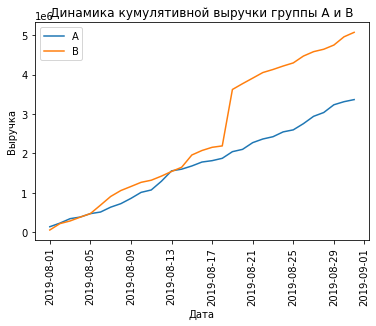

In [34]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'transactions']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'transactions']]

# построение графика выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# построение графика выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# изменение положения подписей на оси X и добавление легенды
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Динамика кумулятивной выручки группы A и B')
plt.show()

**Выводы и предположения**

С 1-го по 17-е число выручка почти равномерно увеличивается, увеличение происходит и в течение всего теста. Хороший знак.
Однако график выручки группы `B` резко растет, более плавный рост наблюдается для группы `A`. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### Построение графика кумулятивного среднего чека по группам

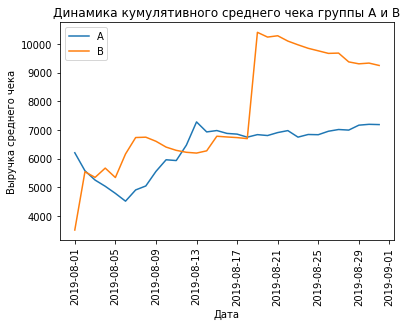

In [35]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['transactions'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['transactions'], label='B')

# изменение положения подписей на оси X и добавление легенды
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Выручка среднего чека')
plt.xlabel('Дата')
plt.title('Динамика кумулятивного среднего чека группы A и B')
plt.show()

**Выводы и предположения**

Куммулятивное значение среднего чека продолжает колебаться. Принимать решения по этой метрике рано. Требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

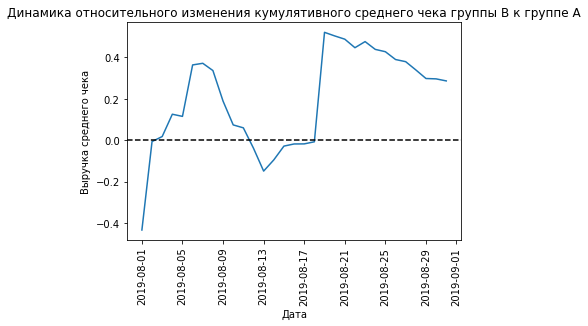

In [36]:
# сбор данных в одном датафрейме
merged_cumulative_revenue = (cumulative_revenue_a
                             .merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                            )

# построение отношения средних чеков
plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB'] / merged_cumulative_revenue['transactionsB']) / 
    (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['transactionsA'])-1
)

# изменение положения подписей на оси
plt.xticks(rotation=90)

# добавление оси X
plt.axhline(y=0, color='black', linestyle='--')

plt.ylabel('Выручка среднего чека')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

**Выводы и предположения**

Результаты теста значительно и резко менялись в несколько дат. Видимо именно тогда были совершены аномальные заказы.

### Построение графика кумулятивной конверсии по группам

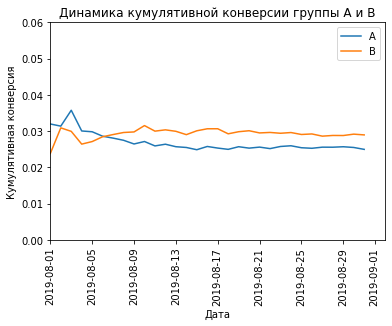

In [37]:
# расчет кумулятивной конверсии
cumulative_data['conversion'] = cumulative_data['transactions'] / cumulative_data['visitors']

# отделение данных по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделение данных по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# построение графиков
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

# масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 2), 0, 0.06])

# изменение положения подписей на оси X и добавление легенды
plt.xticks(rotation=90)
plt.legend()

plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.title('Динамика кумулятивной конверсии группы A и B')
plt.show()

**Выводы и предположения**

В начале теста сегмент `A` имел большую конверсию, конверсия сегмента `B`, после значительного падения, стала возрастать и стала выше конверсии сегмента `A`. Абсолютное колебание в начале и в конце теста не слишком большое: от 3% до 4%.

### Построение графика относительного изменения кумулятивной конверсии группы B к группе A

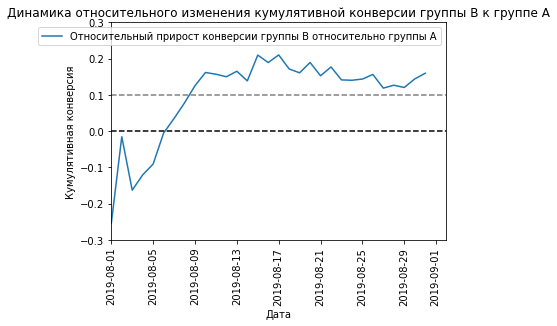

In [38]:
# подготовка данных
merged_cumulative_conversions = (cumulative_data_a[['date','conversion']]
                                 .merge(cumulative_data_b[['date','conversion']]
                                        , left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                                )

# построение графика
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A"
        )

# изменение положения подписей на оси X и добавление легенды
plt.xticks(rotation=90)
plt.legend()

# добавление осей X и масштаб осей
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 2), -0.3, 0.3])

plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.title('Динамика относительного изменения кумулятивной конверсии группы B к группе A')
plt.show()

**Выводы и предположения**

Почти с самого начала теста, после небольшого падения, группа `B` лидирует по конверсии: заметен значительный прирост, после - зафиксироварась около прироста в 10%, далее снова заметно небольшое возрастание относительно группы `A`.

### Построение точечного графика количества заказов по пользователям

In [40]:
# подсчет количества заказов по пользователям
transactions_by_visitors = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

transactions_by_visitors.columns = ['visitor_id', 'transactions']

display(transactions_by_visitors.sort_values(by='transactions', ascending=False).head(10))

,visitor_id,transactions
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


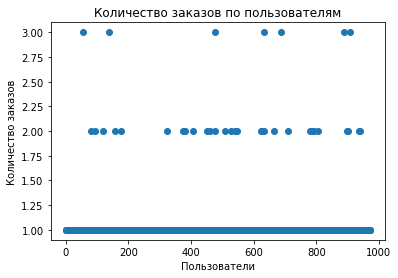

In [41]:
x_values = pd.Series(range(0,len(transactions_by_visitors)))

plt.scatter(x_values, transactions_by_visitors['transactions'])

# подписи осей и название графика
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи')
plt.title('Количество заказов по пользователям')
plt.show()

**Выводы и предположения**

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна.

### Расчет 95-й и 99-й перцентили количества заказов на пользователя

In [42]:
print(np.percentile(transactions_by_visitors['transactions'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше чем 1 заказ. И 1% пользователей заказывали более 2 раз. В данном случае, разумно выбрать 1 заказ на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### Построение точечного графика стоимостей заказов

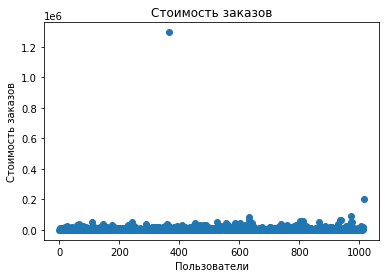

In [44]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])

# подписи осей и название графика
plt.ylabel('Стоимость заказов')
plt.xlabel('Пользователи')
plt.title('Стоимость заказов')
plt.show()

**Выводы и предположения**

В основном все заказы распределены, приблизительно, около 50 000 рублей. Есть несколько аномальных выбросов в районе 200 000 рублей и в районе 1 300 000.

### Подсчет 95-й и 99-й перцентили стоимости заказов

In [45]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей.

### Расчет статистической значимости различий в конверсии между группами по «сырым» данным

In [46]:
# подготовка данных
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}),axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}),axis=1
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

transactions_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
transactions_a_daily.columns = ['date', 'transactions_per_date_a', 'revenue_per_date_a']

transactions_a_cummulative = transactions_a_daily.apply(
    lambda x: transactions_a_daily[transactions_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'transactions_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),axis=1).sort_values(by=['date'])

transactions_a_cummulative.columns = ['date', 'transactions_cummulative_a', 'revenue_cummulative_a']

transactions_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
transactions_b_daily.columns = ['date', 'transactions_per_date_b', 'revenue_per_date_b']

transactions_b_cummulative = transactions_b_daily.apply(
    lambda x: transactions_b_daily[transactions_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'transactions_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}),axis=1,).sort_values(by=['date'])
transactions_b_cummulative.columns = ['date', 'transactions_cummulative_b', 'revenue_cummulative_b']

data = (
    transactions_a_daily.merge(
        transactions_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(transactions_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(transactions_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,transactions_per_date_a,revenue_per_date_a,transactions_per_date_b,revenue_per_date_b,transactions_cummulative_a,revenue_cummulative_a,transactions_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


***Описание данных таблицы `data`:***

- `transactions_per_date_a` — количество заказов в выбранную дату в группе A;
- `revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;
- `transactions_per_date_b` — количество заказов в выбранную дату в группе B;
- `revenue_per_date_b` — суммарная выручка в выбранную дату в группе B;
- `transactions_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;
- `transactions_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;
- `visitors_per_date_a` — количество пользователей в выбранную дату в группе A;
- `visitors_per_date_b` — количество пользователей в выбранную дату в группе B;
- `visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;
- `visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.

*Гипотеза №1: В конверсии между группами по «сырым» данным отсутствуют статистически значимые различия:*

H₀: В конверсии между группами `A` и `B` отсутствуют статистически значимые различия;

H₁: В конверсии между группами `A` и `B` присутствуют статистически значимые различия.

Исходя из формулировки гипотезы о том, что в конверсии между группами по «сырым» данным отсутствуют статистически значимые различия, были сформулированы нулевая(H₀) и альтернативная гипотезы(H₁), для нулевой сделано предположение о том, что в конверсии между группами `A` и `B` отсутствуют статистически значимые различия, а для альтернативной, наоборот, в конверсии между группами `A` и `B` присутствуют статистически значимые различия.

In [49]:
# расчет статистической значимости конверсии
transactions_by_visitors_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
transactions_by_visitors_a.columns = ['visitor_id', 'transactions']

transactions_by_visitors_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
transactions_by_visitors_b.columns = ['visitor_id', 'transactions']

sample_a = pd.concat(
    [transactions_by_visitors_a['transactions'], pd.Series(0, index=np.arange(
        data['visitors_per_date_a'].sum() - len(transactions_by_visitors_a['transactions'])
            ), name='transactions')], axis=0
)

sample_b = pd.concat(
    [transactions_by_visitors_b['transactions'], pd.Series(0, index=np.arange(
        data['visitors_per_date_b'].sum() - len(transactions_by_visitors_b['transactions'])
            ),name='transactions')], axis=0
)

print("{0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_a.mean() / sample_b.mean() - 1))

0.011
-0.138


**Выводы и предположения**

P-value = 0.011, меньше 0.05, поэтому гипотеза о том, что конверсии между группами по «сырым» данным отсутствуют статистически значимые различия, отвергается. Относительный проигрыш группы `B` равен  13.8%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

*Гипотеза №2: В среднем чеке между группами по «сырым» данным отсутствуют статистически значимые различия:*

H₀: В среднем чеке между группами `A` и `B` отсутствуют статистически значимые различия;

H₁: В среднем чеке между группами `A` и `B` присутствуют статистически значимые различия.

Исходя из формулировки гипотезы о том, что в среднем чеке между группами по «сырым» данным отсутствуют статистически значимые различия, были сформулированы нулевая(H₀) и альтернативная гипотезы(H₁), для нулевой сделано предположение о том, что в среднем чеке между группами `A` и `B` отсутствуют статистически значимые различия, а для альтернативной, наоборот, в среднем чеке между группами `A` и `B` присутствуют статистически значимые различия.

In [50]:
print('{0:.3f}'.format(
    st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                       orders[orders['group']=='B']['revenue'])[1])
     )
print('{0:.3f}'.format(
    orders[orders['group']=='B']['revenue']
    .mean()/orders[orders['group']=='A']['revenue'].mean()-1)
     )

0.829
0.287


**Выводы и предположения**

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что среднем чеке между группами по «сырым» данным отсутствуют статистически значимые различия, нет. Наблюдаемое различие в 28,7% - не является статистически значимым.

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

In [51]:
# аномальные пользователи
visitors_with_many_transactions = pd.concat(
    [
        transactions_by_visitors_a[transactions_by_visitors_a['transactions'] > 1]['visitor_id'],
        transactions_by_visitors_b[transactions_by_visitors_b['transactions'] > 1]['visitor_id'],
    ],
    axis=0,
)

revenue_lim = np.percentile(orders['revenue'], 95)

visitors_with_expensive_transactions = orders[orders['revenue'] > revenue_lim]['visitor_id']

abnormal_visitors = (
    pd.concat([visitors_with_many_transactions, visitors_with_expensive_transactions], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_visitors.head(5))
print(abnormal_visitors.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

86


Всего 86 аномальных пользователя.

*Гипотеза №3: В конверсии между группами по «очищенным» данным отсутствуют статистически значимые различия:*

H₀: В конверсии между группами `A` и `B` отсутствуют статистически значимые различия;

H₁: В конверсии между группами `A` и `B` присутствуют статистически значимые различия.

Исходя из формулировки гипотезы о том, что в конверсии между группами по «очищенным» данным отсутствуют статистически значимые различия, были сформулированы нулевая(H₀) и альтернативная гипотезы(H₁), для нулевой сделано предположение о том, что в конверсии между группами `A` и `B` отсутствуют статистически значимые различия, а для альтернативной, наоборот, в конверсии между группами `A` и `B` присутствуют статистически значимые различия.

In [52]:
# расчет статистической значимости различий в среднем чеке заказа
sample_a_filtered = pd.concat(
    [transactions_by_visitors_a[np.logical_not(transactions_by_visitors_a['visitor_id'].isin(abnormal_visitors))
                               ]['transactions'], pd.Series(
        0, index=np.arange(data['visitors_per_date_a'].sum() - len(transactions_by_visitors_a['transactions'])
                          ), name='transactions')
    ], axis=0
)

sample_b_filtered = pd.concat(
    [transactions_by_visitors_b[np.logical_not(transactions_by_visitors_b['visitor_id'].isin(abnormal_visitors))
                               ]['transactions'], pd.Series(
        0, index=np.arange(data['visitors_per_date_b'].sum() - len(transactions_by_visitors_b['transactions'])
                          ), name='transactions')
    ], axis=0
)

print('{0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

0.016
0.174


**Выводы и предположения**

P-value = 0.016, меньше 0.05. Как и в конверсии по «сырым» данных, в «очищеных» данных гипотеза о том, что конверсии между группами по «очищенным» данным отсутствуют статистически значимые различия, отвергается. Относительный проигрыш группы `B` равен  17.4%.

### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

*Гипотеза №4: В среднем чеке между группами по «очищенным» данным отсутствуют статистически значимые различия:*

H₀: В среднем чеке между группами `A` и `B` отсутствуют статистически значимые различия;

H₁: В среднем чеке между группами `A` и `B` присутствуют статистически значимые различия.

Исходя из формулировки гипотезы о том, что в среднем чеке между группами по «очищенным» данным отсутствуют статистически значимые различия, были сформулированы нулевая(H₀) и альтернативная гипотезы(H₁), для нулевой сделано предположение о том, что в среднем чеке между группами `A` и `B` отсутствуют статистически значимые различия, а для альтернативной, наоборот, в среднем чеке между группами `A` и `B` присутствуют статистически значимые различия.

In [53]:
print('{0:.3f}'.format(
    st.mannwhitneyu(orders[np.logical_and(
        orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'],
                    orders[np.logical_and(orders['group'] == 'B',np.logical_not(
                        orders['visitor_id'].isin(abnormal_visitors)))]['revenue'])[1]
)
     )

print("{0:.3f}".format(
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]
    ['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(
        orders['visitor_id'].isin(abnormal_visitors)))
        ]['revenue'].mean()- 1
)
     ) 

0.727
-0.034


**Выводы и предположения**

P-value значительно больше 0.05 как и в случае с «сырыми» данными. Гипотеза о том, что в среднем чеке между группами по «очищенным» данным отсутствуют статистически значимые различия - не отвергается. Наблюдаемое различие, значительно сократилось в отличии от «сырых» данных и составляет 3,4% - не является статистически значимым.

## Шаг 5. Решение по результатам теста

- Есть статистически значимое различие по конверсии между группами как по «сырым» данным, так и по «очищенным» данным;
- Нет статистически значимого различия по среднему чеку между группами как по «сырым» данным, так и по «очищенным» данным;
- График различия конверсии между группами сообщает, что результаты группы `B` лучше группы `A`;
- График различия среднего чека говорит о том, что результаты группы `B` улучшаются день ото дня.

Решение: Остановить тест, группа `B` показывает лучшие результаты, чем группа `A`.